## WeRateDogs Trends and Findings

### Introduction

The goal of this project is to wrangle the WeRateDogs Twitter data to create interesting and trustworthy analyses and visualizations. The challenge lies in the fact that the Twitter archive is great, but it only contains very basic tweet information that comes in JSON format. For a successful project, I needed to gather, asses and clean the Twitter data for a worthy analysis and visualization.

In [1]:
# Import the libraries needed for this project
import pandas as pd
import numpy as np

import requests
import tweepy
import json

import time
from IPython.display import clear_output
from IPython.display import HTML

import os
import re

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

### Gathering the Data

#### 1) WeRateDogs Twitter Archive

In [2]:
#Tweet text max 140 charectors plus 3 for pandas
pd.options.display.max_colwidth = 143

In [3]:
# WeRateDogs Twitter archive file obtained as a csv file. Pandas dataframe created from csv file.
twitter_archive_df = pd.read_csv('twitter-archive-enhanced.csv')

In [4]:
# Exploration of data in file
twitter_archive_df.head(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 ...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None


In [5]:
# Exploration of data types and missing data.
twitter_archive_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

#### 2) Tweet Image Predictions

In [6]:
# downloading image_predictions.tsv file programatically
url = "https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"
response = requests.get(url)

with open('image_predictions.tsv', 'wb') as f:
    f.write(response.content)

In [7]:
#create a folder for image predictions data
folder_name = 'image_predictions'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

In [8]:
image_predictions_df = pd.read_csv('image-predictions.tsv', sep='\t')

In [9]:
# Exploration of data in file
image_predictions_df.head(3)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True


In [10]:
# Exploration of data types and missing fields.
image_predictions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


#### 3) Twitter API 

In [12]:
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth,
                 parser=tweepy.parsers.JSONParser(),
                 wait_on_rate_limit=True,
                 wait_on_rate_limit_notify=True)

In [13]:
# Creating list of tweet ids
tweet_id = twitter_archive_df['tweet_id']
list(tweet_id)

[892420643555336193,
 892177421306343426,
 891815181378084864,
 891689557279858688,
 891327558926688256,
 891087950875897856,
 890971913173991426,
 890729181411237888,
 890609185150312448,
 890240255349198849,
 890006608113172480,
 889880896479866881,
 889665388333682689,
 889638837579907072,
 889531135344209921,
 889278841981685760,
 888917238123831296,
 888804989199671297,
 888554962724278272,
 888202515573088257,
 888078434458587136,
 887705289381826560,
 887517139158093824,
 887473957103951883,
 887343217045368832,
 887101392804085760,
 886983233522544640,
 886736880519319552,
 886680336477933568,
 886366144734445568,
 886267009285017600,
 886258384151887873,
 886054160059072513,
 885984800019947520,
 885528943205470208,
 885518971528720385,
 885311592912609280,
 885167619883638784,
 884925521741709313,
 884876753390489601,
 884562892145688576,
 884441805382717440,
 884247878851493888,
 884162670584377345,
 883838122936631299,
 883482846933004288,
 883360690899218434,
 883117836046

In [14]:
#Investigating the first tweet for information available.
tweet = api.get_status(tweet_id[0])
tweet

{'created_at': 'Tue Aug 01 16:23:56 +0000 2017',
 'id': 892420643555336193,
 'id_str': '892420643555336193',
 'text': "This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU",
 'truncated': False,
 'entities': {'hashtags': [],
  'symbols': [],
  'user_mentions': [],
  'urls': [],
  'media': [{'id': 892420639486877696,
    'id_str': '892420639486877696',
    'indices': [86, 109],
    'media_url': 'http://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg',
    'media_url_https': 'https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg',
    'url': 'https://t.co/MgUWQ76dJU',
    'display_url': 'pic.twitter.com/MgUWQ76dJU',
    'expanded_url': 'https://twitter.com/dog_rates/status/892420643555336193/photo/1',
    'type': 'photo',
    'sizes': {'thumb': {'w': 150, 'h': 150, 'resize': 'crop'},
     'medium': {'w': 540, 'h': 528, 'resize': 'fit'},
     'small': {'w': 540, 'h': 528, 'resize': 'fit'},
     'large': {'w': 540, 'h': 528, 'resize': 'fit'}}}]},


In [18]:
from IPython.display import clear_output

# Iterate over tweet_ids to obtain favorites and retweet count. Then append these has dicts into df_list.
df_list = []

# Any tweet_ids not found by API, are appended to e_list
e_list = []

query_success_count = 0

for id in tweet_id:
    try:
        # get the start time of query
        start_time = time.time()
        # query each id using get_status
        page = api.get_status(id, tweet_mode = 'extended')
        favorites = page['favorite_count']
        retweet_count = page['retweet_count']
        df_list.append({'tweet_id': int(id),
                        'favorite_count': int(favorites),
                        'retweet_count': int(retweet_count)
                       })
        # count the number of successes in querying the status and recording its data
        query_success_count += 1
        end_time = time.time()
        clear_output()
        print('Query No.:',query_success_count)
        print('Query for id {}, No. of Favorites counts: {} and No. of times retweeted: {} is successful. Time taken (s): {}'.format(id, favorites, retweet_count, end_time-start_time))
    
    except Exception as e:
        e_list.append(id)
        clear_output()
        print('Query for id {} unsuccessful. Error recorded in error_list'.format(id))

clear_output()
print('Query completed.')

Query completed.


In [19]:
# check the number of successes
query_success_count

2332

In [20]:
# Analysis of first 5 tweets to ensure iteration has worked correctly
df_list[:5]

[{'tweet_id': 892420643555336193,
  'favorite_count': 37189,
  'retweet_count': 7966},
 {'tweet_id': 892177421306343426,
  'favorite_count': 31993,
  'retweet_count': 5912},
 {'tweet_id': 891815181378084864,
  'favorite_count': 24096,
  'retweet_count': 3909},
 {'tweet_id': 891689557279858688,
  'favorite_count': 40510,
  'retweet_count': 8107},
 {'tweet_id': 891327558926688256,
  'favorite_count': 38743,
  'retweet_count': 8799}]

In [21]:
# View list of exceptions
e_list

[888202515573088257,
 873697596434513921,
 872668790621863937,
 872261713294495745,
 869988702071779329,
 866816280283807744,
 861769973181624320,
 856602993587888130,
 851953902622658560,
 845459076796616705,
 844704788403113984,
 842892208864923648,
 837366284874571778,
 837012587749474308,
 829374341691346946,
 827228250799742977,
 812747805718642688,
 802247111496568832,
 779123168116150273,
 775096608509886464,
 771004394259247104,
 770743923962707968,
 754011816964026368,
 680055455951884288]

In [23]:
# Try re-iteration for tweet_ids in exception list as suggested by other students to see if there was an error the 
# first time.   
ee_list = []

for e in e_list:
    try:
        page = api.get_status(e, tweet_mode = 'extended')
        favorite_count = page['favorite_count']
        retweet_count = page['retweet_count']
        
        df_list.append({'tweet_id': int(e),
                        'favorite_count': int(favorites),
                        'retweet_count': int(retweets)
                        })
        
    except Exception:
        ee_list.append(e)

In [24]:
# View list of exceptions again. The presumption is these tweets are no longer available to get with the API.
df_list

[{'tweet_id': 892420643555336193,
  'favorite_count': 37189,
  'retweet_count': 7966},
 {'tweet_id': 892177421306343426,
  'favorite_count': 31993,
  'retweet_count': 5912},
 {'tweet_id': 891815181378084864,
  'favorite_count': 24096,
  'retweet_count': 3909},
 {'tweet_id': 891689557279858688,
  'favorite_count': 40510,
  'retweet_count': 8107},
 {'tweet_id': 891327558926688256,
  'favorite_count': 38743,
  'retweet_count': 8799},
 {'tweet_id': 891087950875897856,
  'favorite_count': 19472,
  'retweet_count': 2923},
 {'tweet_id': 890971913173991426,
  'favorite_count': 11362,
  'retweet_count': 1943},
 {'tweet_id': 890729181411237888,
  'favorite_count': 62746,
  'retweet_count': 17745},
 {'tweet_id': 890609185150312448,
  'favorite_count': 26789,
  'retweet_count': 4029},
 {'tweet_id': 890240255349198849,
  'favorite_count': 30685,
  'retweet_count': 6933},
 {'tweet_id': 890006608113172480,
  'favorite_count': 29521,
  'retweet_count': 6890},
 {'tweet_id': 889880896479866881,
  'favor

In [25]:
# With the data collected, create a pandas dataframe
json_tweets_df = pd.DataFrame(df_list, columns = ['tweet_id', 'favorite_count', 'retweet_count'])

In [26]:
# Save a copy of the data to a txt file for future reference as requested by the project
json_tweets_df.to_csv('tweet_json.txt',encoding='utf-8',index=False)

In [27]:
# Created a csv file in order to download and open without issues in Excel for visual inspection
json_tweets_df.to_csv('tweet_json.csv',encoding='utf-8',index=False)

In [28]:
json_tweets_df.head()

,tweet_id,favorite_count,retweet_count
0,892420643555336193,37189,7966
1,892177421306343426,31993,5912
2,891815181378084864,24096,3909
3,891689557279858688,40510,8107
4,891327558926688256,38743,8799


## Assessing the Data

**From the key points section of the project submission - Assess the datasets with the following end result in mind - We want "only originial ratings (no retweets) that have images"**  

After gathering each of the above pieces of data, assess them visually and programmatically for quality and tidiness issues. Detect and document at least eight (8) quality issues and two (2) tidiness issues in your wrangle_act.ipynb Jupyter Notebook. To meet specifications, the issues that satisfy the Project Motivation must be assessed.

#### Visually with Excel and Pandas    

During the gathering stage, each of the three datasets were opened in pandas with df.head() and df.info() in order to get a feel for the datasets.

The csv files for each dataset were downloaded and opened in Excel. The dataset with around 2500 rows was manageable in Excel and using the filters function gave a good feel of the data inside each of the three datasets. From Excel it was quickly identified the many incorrect names in the dataset for the dogs and the strange rating scores being used for both denominator when you would only expect 10 and for the numerator.

#### Programmatically   

Some further sampling and investigation was done in pandas using df.info(),  df.head(),  df.sample(),  df\['column'].value_counts() - see below.

### Issues to clean

Below is a list of issues found that need cleaning.

### Quality (completeness, validity, accuracy, and consistency issues)

- (3) "twitter_archive_df" has 2356 rows while the "image_predictions_df" has only 2075 rows, probably due to retweets and missing photos.
- (2) "twitter_archive_df" contains 181 retweets and 78 replies which not needed.
- (6) there are many names of dogs which are clearly incorrect such as 'a', 'actually', 'all'   
- (7) strange unexpected values in rating_denominator   
- (8) strange unexpected values in rating_numerator    
- (9) source data column is not clear    
- (10) timestamp column has not necessary +0000   
- (11) not all the data are in their most appropriate data type   
- (12) consistent names and logical order to column data as final step in cleaning


### Tidiness (structural issues)

- (1) there are 3 dataframes, only 1 dataframe should suffice to incorporate the data we need.
- (4) there are 4 columns for doggo, floffer, pupper, and puppo in the "twitter_archive_df" but this is same categorical data that would be better in only 1 column.
- (5) there are 3 predictions for the dog breed in the "image_predictions_df" but maybe the best prediction will suffice to reduce the size of the final dataframe.

In [29]:
# In the gathering sections, each of the 3 datasets were viewed programmatically with df.head() and df.info()
# to get a basic understanding of the columns and datatypes.

# Programmatical sampling on each of the dataframes
twitter_archive_df.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2309,666804364988780544,NaN,NaN,2015-11-18 02:25:23 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Jockson. He is a Pinnacle Sagittarius. Fancy bandana. Enjoys lightly sucking on hot dog in nature. 8/10 https://t.co/RdKbAOEpDK,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666804364988780544/photo/1,8,10,Jockson,None,None,None,None
1560,688519176466644993,NaN,NaN,2016-01-17 00:32:18 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This pupper is sprouting a flower out of her head. 12/10 revolutionary af https://t.co/glmvQBRjv4,NaN,NaN,NaN,https://twitter.com/dog_rates/status/688519176466644993/photo/1,12,10,None,None,None,pupper,None
1645,683849932751646720,NaN,NaN,2016-01-04 03:18:23 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Jiminy. He's not the brightest dog. Needs to lay off the kibble. 5/10 still petable https://t.co/omln4LOy1x,NaN,NaN,NaN,https://twitter.com/dog_rates/status/683849932751646720/photo/1,5,10,Jiminy,None,None,None,None
2046,671520732782923777,NaN,NaN,2015-12-01 02:46:33 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Alejandro. He's an extremely seductive pup. 10/10 https://t.co/C7dPcCUNpF,NaN,NaN,NaN,https://twitter.com/dog_rates/status/671520732782923777/photo/1,10,10,Alejandro,None,None,None,None
208,852311364735569921,NaN,NaN,2017-04-13 00:03:59 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Wiggles. She would like you to spot her. Probably won't need your help but just in case. 13/10 powerful as h*ck https://t.co/2d370P...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/852311364735569921/photo/1,13,10,Wiggles,None,None,None,None


In [30]:
image_predictions_df.sample(10)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1914,854120357044912130,https://pbs.twimg.com/media/C9px7jyVwAAnmwN.jpg,4,black-and-tan_coonhound,0.854861,True,Doberman,0.050792,True,bluetick,0.021762,True
230,670408998013820928,https://pbs.twimg.com/media/CU3FbQgVAAACdCQ.jpg,1,ping-pong_ball,0.999945,False,tennis_ball,0.000018,False,racket,0.000015,False
573,678424312106393600,https://pbs.twimg.com/media/CWo_T8gW4AAgJNo.jpg,1,Maltese_dog,0.759945,True,toy_poodle,0.101194,True,Shih-Tzu,0.056037,True
1250,747885874273214464,https://pbs.twimg.com/media/CmEGMSvUYAAl3ZM.jpg,1,kuvasz,0.408450,True,Samoyed,0.141330,True,pug,0.083018,True
383,673342308415348736,https://pbs.twimg.com/media/CVgxQc5XIAAYL0W.jpg,1,ski_mask,0.981017,False,Chihuahua,0.013559,True,kelpie,0.000652,True
1781,828708714936930305,https://pbs.twimg.com/media/C4AqLSgVYAEg8nt.jpg,1,hippopotamus,0.942911,False,Mexican_hairless,0.008388,True,ice_lolly,0.006206,False
32,666428276349472768,https://pbs.twimg.com/media/CT-g-0DUwAEQdSn.jpg,1,Pembroke,0.371361,True,chow,0.249394,True,Pomeranian,0.241878,True
810,692187005137076224,https://pbs.twimg.com/media/CZskaEIWIAUeTr5.jpg,2,Siberian_husky,0.810592,True,malamute,0.119745,True,Eskimo_dog,0.029265,True
302,671504605491109889,https://pbs.twimg.com/media/CVGp4LKWoAAoD03.jpg,1,toy_poodle,0.259115,True,bath_towel,0.177669,False,Maltese_dog,0.071712,True
841,694905863685980160,https://pbs.twimg.com/media/CaTNMUgUYAAB6vs.jpg,1,bow_tie,0.449268,False,fur_coat,0.139099,False,black-footed_ferret,0.082232,False


In [31]:
twitter_archive_df.name.value_counts()

None         745
a             55
Charlie       12
Lucy          11
Oliver        11
Cooper        11
Tucker        10
Penny         10
Lola          10
Winston        9
Bo             9
Sadie          8
the            8
Buddy          7
an             7
Daisy          7
Bailey         7
Toby           7
Dave           6
Milo           6
Bella          6
Leo            6
Jack           6
Rusty          6
Oscar          6
Koda           6
Jax            6
Scout          6
Stanley        6
Alfie          5
            ... 
Banjo          1
Eevee          1
Mo             1
Fynn           1
Pete           1
Mairi          1
Zoe            1
Harvey         1
Eleanor        1
Cheesy         1
Kevon          1
Mary           1
Deacon         1
Mitch          1
Goliath        1
Griswold       1
Chloe          1
Zeek           1
Saydee         1
Bruiser        1
Monster        1
Jo             1
Shadoe         1
Barclay        1
Toffee         1
Berb           1
Tito           1
Stephanus     

In [32]:
twitter_archive_df.rating_denominator.value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [33]:
twitter_archive_df.rating_numerator.value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [34]:
twitter_archive_df.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

## Cleaning the Data

In [35]:
# Creat a copy of the original 3 datasets for reference
archive_clean_df = twitter_archive_df.copy()
image_clean_df = image_predictions_df.copy()
json_clean_df = json_tweets_df.copy() 

In [36]:
# Save a copy of the clean datasets to work with
archive_clean_df.to_csv('archive_clean.csv',encoding='utf-8',index=False)
image_clean_df.to_csv('image_clean.csv',encoding='utf-8',index=False)
json_clean_df.to_csv('json_clean.csv',encoding='utf-8',index=False)

In [37]:
# Load clean datasets
archive_clean_df = pd.read_csv('archive_clean.csv')
image_clean_df = pd.read_csv('image_clean.csv')
json_clean_df = pd.read_csv('json_clean.csv')

#### 1) Merge the 3 dataframes into 1 master dataframe

In [38]:
# Merge the three DataFrames into one master DataFrame, starting first with archive_clean and json_clean
first_archive_master_df = pd.merge(archive_clean_df, json_clean_df, on=['tweet_id','tweet_id'],how='left') 

In [39]:
# Check merge went as anticipated
first_archive_master_df.head(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,favorite_count,retweet_count
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None,37189.0,7966.0
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 ...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None,31993.0,5912.0


In [40]:
# Merge new master with image_clean
first_archive_master_df = pd.merge(first_archive_master_df, image_clean_df, on='tweet_id',how='left') 

In [41]:
# Increase number of visible columns in a pandas DataFrame to see all the columns in the newly created master_df
pd.set_option("display.max_columns",30)

In [42]:
# Check merge went as anticipated
first_archive_master_df.head(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,favorite_count,retweet_count,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None,37189.0,7966.0,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1.0,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 ...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None,31993.0,5912.0,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1.0,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True


In [43]:
# Check twitter_archive_master_df
first_archive_master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 30 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
favorite_count                23

In [44]:
# Save a copy of the newly created master dataframe has a starting point for cleaning
first_archive_master_df.to_csv('first_archive_master.csv',encoding='utf-8',index=False)

In [45]:
df = pd.read_csv('first_archive_master.csv')

#### 2)  Remove Retweets and Replies

In [46]:
# there are 181 retweets, which can be seen in the 3 columns "retweeted_status_id", "retweeted_status_user_id" and 
# "retweeted_status_timestamp". We keep the rows that are null and remove the retweets.
df = df[df.retweeted_status_id.isnull()]

In [47]:
# check retweets have gone
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 30 columns):
tweet_id                      2175 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2175 non-null object
source                        2175 non-null object
text                          2175 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2117 non-null object
rating_numerator              2175 non-null int64
rating_denominator            2175 non-null int64
name                          2175 non-null object
doggo                         2175 non-null object
floofer                       2175 non-null object
pupper                        2175 non-null object
puppo                         2175 non-null object
favorite_count                2168 non

In [48]:
# delete the columns related to retweets from the master dataframe.
df = df.drop(['retweeted_status_id','retweeted_status_user_id','retweeted_status_timestamp'],axis=1)

In [49]:
# check the retweet columns have gone.
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 27 columns):
tweet_id                 2175 non-null int64
in_reply_to_status_id    78 non-null float64
in_reply_to_user_id      78 non-null float64
timestamp                2175 non-null object
source                   2175 non-null object
text                     2175 non-null object
expanded_urls            2117 non-null object
rating_numerator         2175 non-null int64
rating_denominator       2175 non-null int64
name                     2175 non-null object
doggo                    2175 non-null object
floofer                  2175 non-null object
pupper                   2175 non-null object
puppo                    2175 non-null object
favorite_count           2168 non-null float64
retweet_count            2168 non-null float64
jpg_url                  1994 non-null object
img_num                  1994 non-null float64
p1                       1994 non-null object
p1_conf              

In [50]:
# View the state of the dataframe
df.head(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,favorite_count,retweet_count,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None,37189.0,7966.0,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1.0,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 ...",https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None,31993.0,5912.0,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1.0,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True


In [51]:
# the "in_reply_to_status_id" includes the original tweet_id if there is a reply. There are 78 replies.
# We keep the rows that are null and remove the replies.
df = df[df.in_reply_to_status_id.isnull()]

In [52]:
# check the replies have gone
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 27 columns):
tweet_id                 2097 non-null int64
in_reply_to_status_id    0 non-null float64
in_reply_to_user_id      0 non-null float64
timestamp                2097 non-null object
source                   2097 non-null object
text                     2097 non-null object
expanded_urls            2094 non-null object
rating_numerator         2097 non-null int64
rating_denominator       2097 non-null int64
name                     2097 non-null object
doggo                    2097 non-null object
floofer                  2097 non-null object
pupper                   2097 non-null object
puppo                    2097 non-null object
favorite_count           2090 non-null float64
retweet_count            2090 non-null float64
jpg_url                  1971 non-null object
img_num                  1971 non-null float64
p1                       1971 non-null object
p1_conf                

In [53]:
# delete the columns related to replies from the master dataframe.
df = df.drop(['in_reply_to_status_id','in_reply_to_user_id'],axis=1)

In [111]:
# check the replies columns have gone.
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1964 entries, 0 to 2355
Data columns (total 25 columns):
tweet_id              1964 non-null int64
timestamp             1964 non-null object
source                1964 non-null object
text                  1964 non-null object
expanded_urls         1964 non-null object
rating_numerator      1964 non-null int64
rating_denominator    1964 non-null int64
name                  1964 non-null object
doggo                 1964 non-null object
floofer               1964 non-null object
pupper                1964 non-null object
puppo                 1964 non-null object
favorite_count        1964 non-null float64
retweet_count         1964 non-null float64
jpg_url               1964 non-null object
img_num               1964 non-null float64
p1                    1964 non-null object
p1_conf               1964 non-null float64
p1_dog                1964 non-null object
p2                    1964 non-null object
p2_conf               1964 non-n

In [112]:
# View the state of the dataframe
df.head(2)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,favorite_count,retweet_count,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,892420643555336193,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None,37189.0,7966.0,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1.0,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False
1,892177421306343426,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None,31993.0,5912.0,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1.0,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True


#### 3)  Remove tweets that don't have an image

In [113]:
# After deleting the retweets and replies we still have 126 tweets without an image, as this was one of the project's
# requirements we will delete the tweets without an image. This time we will keep the rows with an image.
df = df[df.jpg_url.notnull()]

In [114]:
# Check that we have an image for each tweet_id
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1964 entries, 0 to 2355
Data columns (total 25 columns):
tweet_id              1964 non-null int64
timestamp             1964 non-null object
source                1964 non-null object
text                  1964 non-null object
expanded_urls         1964 non-null object
rating_numerator      1964 non-null int64
rating_denominator    1964 non-null int64
name                  1964 non-null object
doggo                 1964 non-null object
floofer               1964 non-null object
pupper                1964 non-null object
puppo                 1964 non-null object
favorite_count        1964 non-null float64
retweet_count         1964 non-null float64
jpg_url               1964 non-null object
img_num               1964 non-null float64
p1                    1964 non-null object
p1_conf               1964 non-null float64
p1_dog                1964 non-null object
p2                    1964 non-null object
p2_conf               1964 non-n

#### 4)  Melt the 4 categorical dog types 'doggo', 'floofer', 'pupper', and 'puppo' into 1 column 'dog_type'

In [115]:
# Check how many dog types there are of each
df['doggo'].value_counts()

None     1892
doggo      72
Name: doggo, dtype: int64

In [116]:
df['floofer'].value_counts()

None       1956
floofer       8
Name: floofer, dtype: int64

In [117]:
df['pupper'].value_counts()

None      1755
pupper     209
Name: pupper, dtype: int64

In [118]:
df['puppo'].value_counts()

None     1941
puppo      23
Name: puppo, dtype: int64

In [119]:
# Create list of columns for copying and pasting with melt function
df.columns

Index(['tweet_id', 'timestamp', 'source', 'text', 'expanded_urls',
       'rating_numerator', 'rating_denominator', 'name', 'doggo', 'floofer',
       'pupper', 'puppo', 'favorite_count', 'retweet_count', 'jpg_url',
       'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3',
       'p3_conf', 'p3_dog'],
      dtype='object')

In [120]:
# Melt the 4 columns into a column'types' to be deleted and a value'dog_type'column to keep.
df1 = pd.melt(df, 
        id_vars = ['tweet_id', 'timestamp', 'source', 'text', 'expanded_urls',
       'rating_numerator', 'rating_denominator', 'name', 'favorite_count', 'retweet_count', 'jpg_url', 'img_num',
       'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf',
       'p3_dog'], 
        value_vars = ['doggo', 'floofer', 'pupper', 'puppo'], 
        var_name = 'types', value_name = 'dog_type')

In [121]:
# Check the dataframe structure after melting. We should have 4 copies of each tweet_id, one for each dog type.
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7856 entries, 0 to 7855
Data columns (total 23 columns):
tweet_id              7856 non-null int64
timestamp             7856 non-null object
source                7856 non-null object
text                  7856 non-null object
expanded_urls         7856 non-null object
rating_numerator      7856 non-null int64
rating_denominator    7856 non-null int64
name                  7856 non-null object
favorite_count        7856 non-null float64
retweet_count         7856 non-null float64
jpg_url               7856 non-null object
img_num               7856 non-null float64
p1                    7856 non-null object
p1_conf               7856 non-null float64
p1_dog                7856 non-null object
p2                    7856 non-null object
p2_conf               7856 non-null float64
p2_dog                7856 non-null object
p3                    7856 non-null object
p3_conf               7856 non-null float64
p3_dog                7856 non

In [122]:
# Check we still have all our dog types
df1.dog_type.value_counts()

None       7544
pupper      209
doggo        72
puppo        23
floofer       8
Name: dog_type, dtype: int64

In [123]:
# Sort the dataframe by dog type so that we can drop the 3 duplicates that don't contain a dog type.
df1 = df1.sort_values('dog_type').drop_duplicates('tweet_id', keep = 'last')

In [124]:
# We have lost 10 doggos!
df1.dog_type.value_counts()

None       1662
pupper      209
doggo        62
puppo        23
floofer       8
Name: dog_type, dtype: int64

I couldn't understand why there were 10 doggos less after performing the drop duplicates. I returned to my original Excel spreadsheet and filtered on the doggo column and found that in 14 rows there was more than 1 dog type selected. 

In [125]:
# I had to reiterate over the twitter_archive_master_df in order to identify the 10 tweet_ids. I created a dataframe
# that contained only tweet ids with doggo, floofer, pupper and puppo.
doggos_df = df.drop(['timestamp', 'source', 'text', 'expanded_urls',
       'rating_numerator', 'rating_denominator', 'name', 'favorite_count', 'retweet_count', 'jpg_url', 'img_num',
       'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf',
       'p3_dog'], axis=1)

In [126]:
# I had to set the rows to 75 to be able to see all the rows.
pd.set_option("display.max_rows",75)

# I sorted the dataframe to see all doggos and be able to manually identify the tweet_ids.
doggos_df = doggos_df[doggos_df.doggo != 'None']
doggos_df

,tweet_id,doggo,floofer,pupper,puppo
9,890240255349198849,doggo,None,None,None
43,884162670584377345,doggo,None,None,None
99,872967104147763200,doggo,None,None,None
108,871515927908634625,doggo,None,None,None
121,869596645499047938,doggo,None,None,None
172,858843525470990336,doggo,None,None,None
191,855851453814013952,doggo,None,None,puppo
200,854010172552949760,doggo,floofer,None,None
240,846514051647705089,doggo,None,None,None
248,845397057150107648,doggo,None,None,None


Manually created list from doggos_df showing the tweet_ids that have more than 1 dog type. Then manually read the
text to try to understand the correct dog type. 

Tweet_id.........................Pre-melt types....Correct Dog Type....Need to Change       
855851453814013952 ..doggo/puppo.......puppo......................no               
854010172552949760 ..doggo/floofer.......floofer.......................no                 
817777686764523521 ..doggo/pupper......doggo...................yes to doggo           
808106460588765185 ..doggo/pupper......both - 2 dogs........yes to none           
801115127852503040 ..doggo/pupper......doggo...................yes to doggo          
785639753186217984 ..doggo/pupper......doggo...................yes to doggo          
759793422261743616 ..doggo/pupper......both - 2 dogs........yes to none           
751583847268179968 ..doggo/pupper......none......................yes to none            
741067306818797568 ..doggo/pupper......both - 2 dogs.........yes to none            
733109485275860992 ..doggo/pupper......both - 2 dogs.........yes to none    

In [127]:
# Change dog types identified in the tweet_ids above
df1.loc[df1.tweet_id == 817777686764523521, 'dog_type'] = 'doggo'
df1.loc[df1.tweet_id == 808106460588765185, 'dog_type'] = 'None'
df1.loc[df1.tweet_id == 801115127852503040, 'dog_type'] = 'doggo'
df1.loc[df1.tweet_id == 785639753186217984, 'dog_type'] = 'doggo'
df1.loc[df1.tweet_id == 759793422261743616, 'dog_type'] = 'None'
df1.loc[df1.tweet_id == 751583847268179968, 'dog_type'] = 'None'
df1.loc[df1.tweet_id == 741067306818797568, 'dog_type'] = 'None'
df1.loc[df1.tweet_id == 733109485275860992, 'dog_type'] = 'None'

In [128]:
# Delete column 'types'
df1 = df1.drop('types',axis=1)

In [129]:
# Check the dataframe status and the dog type value counts.
df1.info()
df1.dog_type.value_counts()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1964 entries, 1887 to 6182
Data columns (total 22 columns):
tweet_id              1964 non-null int64
timestamp             1964 non-null object
source                1964 non-null object
text                  1964 non-null object
expanded_urls         1964 non-null object
rating_numerator      1964 non-null int64
rating_denominator    1964 non-null int64
name                  1964 non-null object
favorite_count        1964 non-null float64
retweet_count         1964 non-null float64
jpg_url               1964 non-null object
img_num               1964 non-null float64
p1                    1964 non-null object
p1_conf               1964 non-null float64
p1_dog                1964 non-null object
p2                    1964 non-null object
p2_conf               1964 non-null float64
p2_dog                1964 non-null object
p3                    1964 non-null object
p3_conf               1964 non-null float64
p3_dog                1964 

None       1667
pupper      201
doggo        65
puppo        23
floofer       8
Name: dog_type, dtype: int64

In [130]:
df1.head(2)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,favorite_count,retweet_count,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dog_type
1887,667435689202614272,2015-11-19 20:14:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Ermergerd 12/10 https://t.co/PQni2sjPsm,https://twitter.com/dog_rates/status/667435689202614272/photo/1,12,10,None,303.0,83.0,https://pbs.twimg.com/media/CUM1OHCW4AEgGSi.jpg,1.0,Rottweiler,0.999091,True,miniature_pinscher,0.00045,True,black-and-tan_coonhound,0.000157,True,None
1886,667437278097252352,2015-11-19 20:20:22 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Never seen this breed before. Very pointy pup. Hurts when you cuddle. Still cute tho. 10/10 https://t.co/97HuBrVuOx,https://twitter.com/dog_rates/status/667437278097252352/photo/1,10,10,None,443.0,230.0,https://pbs.twimg.com/media/CUM2qWaWoAUZ06L.jpg,1.0,porcupine,0.989154,False,bath_towel,0.00630,False,badger,0.000966,False,None


#### 5)  Reducing the 3 columns that predict the Breed of the dog in the image to the most likely

In [131]:
# create 2 empty lists to save our choice for each row in the dataset
breed = []
confidence = []

# function that iterates through prediction columns to find the best prediction which is a breed of dog.
def breed_confidence(row):
    if row['p1_dog'] == True:
        breed.append(row['p1'])
        confidence.append(row['p1_conf'])
    elif row['p2_dog'] == True:
        breed.append(row['p2'])
        confidence.append(row['p2_conf'])
    elif row['p3_dog'] == True:
        breed.append(row['p3'])
        confidence.append(row['p3_conf'])
    else:
        breed.append('Unknown')
        confidence.append(0)
        
# call function using pandas apply by columns
df1.apply(breed_confidence, axis=1)

# add lists created to master dataframe
df1['breed'] = breed
df1['confidence'] = confidence

# check the columns have been added
df1.head(2)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,favorite_count,retweet_count,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dog_type,breed,confidence
1887,667435689202614272,2015-11-19 20:14:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Ermergerd 12/10 https://t.co/PQni2sjPsm,https://twitter.com/dog_rates/status/667435689202614272/photo/1,12,10,None,303.0,83.0,https://pbs.twimg.com/media/CUM1OHCW4AEgGSi.jpg,1.0,Rottweiler,0.999091,True,miniature_pinscher,0.00045,True,black-and-tan_coonhound,0.000157,True,None,Rottweiler,0.999091
1886,667437278097252352,2015-11-19 20:20:22 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Never seen this breed before. Very pointy pup. Hurts when you cuddle. Still cute tho. 10/10 https://t.co/97HuBrVuOx,https://twitter.com/dog_rates/status/667437278097252352/photo/1,10,10,None,443.0,230.0,https://pbs.twimg.com/media/CUM2qWaWoAUZ06L.jpg,1.0,porcupine,0.989154,False,bath_towel,0.00630,False,badger,0.000966,False,None,Unknown,0.000000


In [132]:
# Drop predictions and prediction probability columns
df1 = df1.drop(['img_num','p1','p1_conf','p1_dog','p2','p2_conf','p2_dog','p3','p3_conf','p3_dog'],axis=1)

In [133]:
# Check columns have been dropped
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1964 entries, 1887 to 6182
Data columns (total 14 columns):
tweet_id              1964 non-null int64
timestamp             1964 non-null object
source                1964 non-null object
text                  1964 non-null object
expanded_urls         1964 non-null object
rating_numerator      1964 non-null int64
rating_denominator    1964 non-null int64
name                  1964 non-null object
favorite_count        1964 non-null float64
retweet_count         1964 non-null float64
jpg_url               1964 non-null object
dog_type              1964 non-null object
breed                 1964 non-null object
confidence            1964 non-null float64
dtypes: float64(3), int64(3), object(8)
memory usage: 230.2+ KB


#### 6)  Change dog names in names column for clearly incorrect data

In [134]:
# Check the list of dog names.
list(df1['name'])

['None',
 'None',
 'None',
 'Cupcake',
 'Reese',
 'a',
 'None',
 'Philippe',
 'Hall',
 'None',
 'Dook',
 'None',
 'Biden',
 'Naphaniel',
 'a',
 'Kial',
 'George',
 'None',
 'None',
 'Olive',
 'Calvin',
 'a',
 'None',
 'None',
 'None',
 'Filup',
 'Frank',
 'Fwed',
 'None',
 'Genevieve',
 'None',
 'Jockson',
 'Jeph',
 'None',
 'None',
 'None',
 'a',
 'Carll',
 'Klevin',
 'None',
 'Keet',
 'None',
 'Dave',
 'Clybe',
 'Gabe',
 'None',
 'Pipsy',
 'Bradlay',
 'Churlie',
 'Kenneth',
 'Clarence',
 'None',
 'a',
 'Timison',
 'None',
 'None',
 'Joshwa',
 'None',
 'a',
 'Shaggy',
 'None',
 'a',
 'Tedrick',
 'Stu',
 'Erik',
 'Cleopatricia',
 'None',
 'Otis',
 'Jiminy',
 'None',
 'Alfie',
 'None',
 'a',
 'Josep',
 'Lugan',
 'a',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'an',
 'a',
 'an',
 'None',
 'None',
 'None',
 'None',
 'None',
 'a',
 'quite',
 'Walter',
 'None',
 'None',
 'None',
 'None',
 'None',
 'Scout',
 'Kreggory',
 'Jimothy',
 'None',
 'Christoper',
 'None',
 'None

In [135]:
# We see all incorrect names have their first letter has lowercase. We will use this to change them into 'None'. 
names=[]

#function iterates through name column checking if the first letter is lowercase.
def incorrect_name(row):
    if row['name'][0].islower() == True:
        names.append('None')
    else:
        names.append(row['name'])
        
# call function using pandas apply by columns
df1.apply(incorrect_name, axis=1)


#add names list to master dataframe and check dataframe
df1['names'] = names
df1.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,favorite_count,retweet_count,jpg_url,dog_type,breed,confidence,names
1887,667435689202614272,2015-11-19 20:14:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Ermergerd 12/10 https://t.co/PQni2sjPsm,https://twitter.com/dog_rates/status/667435689202614272/photo/1,12,10,None,303.0,83.0,https://pbs.twimg.com/media/CUM1OHCW4AEgGSi.jpg,None,Rottweiler,0.999091,None
1886,667437278097252352,2015-11-19 20:20:22 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Never seen this breed before. Very pointy pup. Hurts when you cuddle. Still cute tho. 10/10 https://t.co/97HuBrVuOx,https://twitter.com/dog_rates/status/667437278097252352/photo/1,10,10,None,443.0,230.0,https://pbs.twimg.com/media/CUM2qWaWoAUZ06L.jpg,None,Unknown,0.000000,None
1885,667443425659232256,2015-11-19 20:44:47 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Exotic dog here. Long neck. Weird paws. Obsessed with bread. Waddles. Flies sometimes (wow!). Very happy dog. 6/10 https://t.co/rqO4I3nf2N,https://twitter.com/dog_rates/status/667443425659232256/photo/1,6,10,None,767.0,561.0,https://pbs.twimg.com/media/CUM8QZwW4AAVsBl.jpg,None,Unknown,0.000000,None
1884,667453023279554560,2015-11-19 21:22:56 +0000,"<a href=""http://twitter.com"" rel=""nofollow"">Twitter Web Client</a>",Meet Cupcake. I would do unspeakable things for Cupcake. 11/10 https://t.co/6uLCWR9Efa,https://twitter.com/dog_rates/status/667453023279554560/photo/1,11,10,Cupcake,304.0,88.0,https://pbs.twimg.com/media/CUNE_OSUwAAdHhX.jpg,None,Labrador_retriever,0.825670,Cupcake
1883,667455448082227200,2015-11-19 21:32:34 +0000,"<a href=""http://twitter.com"" rel=""nofollow"">Twitter Web Client</a>",This is Reese and Twips. Reese protects Twips. Both think they're too good for seat belts. Simply reckless. 7/10s https://t.co/uLzRi1drVK,https://twitter.com/dog_rates/status/667455448082227200/photo/1,7,10,Reese,187.0,59.0,https://pbs.twimg.com/media/CUNHMXTU8AAS3HH.jpg,None,Tibetan_terrier,0.676376,Reese


In [136]:
# print a list to check only names are present
df1['names'].unique()

array(['None', 'Cupcake', 'Reese', 'Philippe', 'Hall', 'Dook', 'Biden',
       'Naphaniel', 'Kial', 'George', 'Olive', 'Calvin', 'Filup', 'Frank',
       'Fwed', 'Genevieve', 'Jockson', 'Jeph', 'Carll', 'Klevin', 'Keet',
       'Dave', 'Clybe', 'Gabe', 'Pipsy', 'Bradlay', 'Churlie', 'Kenneth',
       'Clarence', 'Timison', 'Joshwa', 'Shaggy', 'Tedrick', 'Stu',
       'Erik', 'Cleopatricia', 'Otis', 'Jiminy', 'Alfie', 'Josep',
       'Lugan', 'Walter', 'Scout', 'Kreggory', 'Jimothy', 'Christoper',
       'Phineas', 'Cash', 'Nugget', 'Goose', 'Venti', 'Benedict', 'Nelly',
       'Dante', 'Penny', 'Aja', 'Emmy', 'Shadow', 'Beau', 'Derek',
       'Mingus', 'Maya', 'Canela', 'Jeffrey', 'Gerald', 'Ralphus', 'Zeke',
       'Jim', 'Oliver', 'Ted', 'Bruno', 'Koda', 'Zoey', 'Jax', 'Franklin',
       'Darla', 'Archie', 'Tilly', 'Waffles', 'Jimbo', 'Steven', 'Jack',
       'Duddles', 'Bailey', 'Romeo', 'Jesse', 'Bella', 'Louis', 'Elliot',
       'Gary', 'Rey', 'Koko', 'Alfy', 'Stanley', 'Rusty', '

In [137]:
# update original name column
df1['name'] = df1['names']

In [138]:
# delete names column
df1 = df1.drop('names', axis=1)

In [139]:
# check name column is updated correctly.
df1['name'].value_counts()

None          622
Cooper         10
Oliver         10
Charlie        10
Penny           9
Tucker          9
Lucy            9
Winston         8
Sadie           8
Lola            7
Toby            7
Daisy           7
Koda            6
Stanley         6
Bella           6
Bo              6
Jax             6
Oscar           5
Scout           5
Bailey          5
Leo             5
Milo            5
Louis           5
Buddy           5
Dave            5
Rusty           5
Chester         5
Finn            4
Cassie          4
Jerry           4
Oakley          4
George          4
Bentley         4
Clark           4
Clarence        4
Maggie          4
Jack            4
             ... 
Stephanus       1
Bruiser         1
Zoe             1
Mona            1
Brooks          1
Geno            1
Rhino           1
Baron           1
Comet           1
Bode            1
Wesley          1
Rover           1
Eleanor         1
Chloe           1
Griswold        1
Smiley          1
Patch           1
Longfellow

#### 7)  Investigate surprising values in rating_denominator

In [140]:
# List the different denominators
df1.rating_denominator.value_counts()

10     1947
50        3
80        2
11        2
170       1
150       1
120       1
110       1
90        1
70        1
40        1
20        1
7         1
2         1
Name: rating_denominator, dtype: int64

In [141]:
# Make available a column list for copying and pasting
df1.columns

Index(['tweet_id', 'timestamp', 'source', 'text', 'expanded_urls',
       'rating_numerator', 'rating_denominator', 'name', 'favorite_count',
       'retweet_count', 'jpg_url', 'dog_type', 'breed', 'confidence'],
      dtype='object')

In [142]:
# Create a new dataframe with just tweet_id, text, rating_numerator and rating_denominator
rating_df = df1.drop(['timestamp','source','expanded_urls','name','favorite_count','retweet_count',
 'jpg_url','dog_type','breed','confidence'],axis=1)

In [143]:
# Filter new dataframe to include only denominators not equal to expected 10
rating_df = rating_df[rating_df.rating_denominator != 10]

In [144]:
# Set the column width in pandas so the full tweet text can be read for analysis
pd.set_option("display.max_colwidth",280)

In [145]:
# Display full dataframe
rating_df

,tweet_id,text,rating_numerator,rating_denominator
1943,666287406224695296,This is an Albanian 3 1/2 legged Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10 https://t.co/d9NcXFKwLv,1,2
3271,682962037429899265,This is Darrel. He just robbed a 7/11 and is in a high speed police chase. Was just spotted by the helicopter 10/10 https://t.co/7EsP8LmSp5,7,11
3246,684222868335505415,Someone help the girl is being mugged. Several are distracting her while two steal her shoes. Clever puppers 121/110 https://t.co/1zfnTJLt55,121,110
2921,710658690886586372,Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12,80,80
2939,709198395643068416,"From left to right:\nCletus, Jerome, Alejandro, Burp, &amp; Titson\nNone know where camera is. 45/50 would hug all at once https://t.co/sedre1ivTK",45,50
2876,716439118184652801,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,50,50
2897,713900603437621249,Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1,99,90
3078,697463031882764288,Happy Wednesday here's a bucket of pups. 44/40 would pet all at once https://t.co/HppvrYuamZ,44,40
3003,704054845121142784,Here is a whole flock of puppers. 60/50 I'll take the lot https://t.co/9dpcw6MdWa,60,50
3435,675853064436391936,Here we have an entire platoon of puppers. Total score: 88/80 would pet all at once https://t.co/y93p6FLvVw,88,80


In [146]:
# Reading the text of Tweet_id 666287406224695296 - the correct value should be 9/10
# Change numerator and denominator rating scores in master dataframe df1
df1.loc[df1.tweet_id == 666287406224695296, 'rating_numerator'] = 9
df1.loc[df1.tweet_id == 666287406224695296, 'rating_denominator'] = 10

In [147]:
# Reading the text of Tweet_id 682962037429899265 - the correct value should be 10/10
# Change numerator and denominator rating scores in master dataframe df1
df1.loc[df1.tweet_id == 682962037429899265, 'rating_numerator'] = 10
df1.loc[df1.tweet_id == 682962037429899265, 'rating_denominator'] = 10

In [148]:
# Reading the text of Tweet_id 716439118184652801 - the correct value should be 11/10
# Change numerator and denominator rating scores in master dataframe df1
df1.loc[df1.tweet_id == 716439118184652801, 'rating_numerator'] = 11
df1.loc[df1.tweet_id == 716439118184652801, 'rating_denominator'] = 10

In [149]:
# Reading the text of Tweet_id 810984652412424192 - there is no correct value in the text so allocated 10/10
# so has to be neutral
# Change numerator and denominator rating scores in master dataframe df1
df1.loc[df1.tweet_id == 810984652412424192, 'rating_numerator'] = 10
df1.loc[df1.tweet_id == 810984652412424192, 'rating_denominator'] = 10

In [150]:
# Reading the text of Tweet_id 740373189193256964 - the correct value should be 14/10
# Change numerator and denominator rating scores in master dataframe df1
df1.loc[df1.tweet_id == 740373189193256964, 'rating_numerator'] = 14
df1.loc[df1.tweet_id == 740373189193256964, 'rating_denominator'] = 10

In [151]:
# Reading the text of Tweet_id 722974582966214656 - the correct value should be 13/10
# Change numerator and denominator rating scores in master dataframe df1
df1.loc[df1.tweet_id == 722974582966214656, 'rating_numerator'] = 13
df1.loc[df1.tweet_id == 722974582966214656, 'rating_denominator'] = 10

- The other strange denominator ratings are due to the tweet being based on groups of dogs and the tweeter has given a rating for each member of the group. I'll leave these ratings as it reflects the text and photo.

In [152]:
# check the above changes to the rating_denominator have occurred
df1.rating_denominator.value_counts()

10     1953
80        2
50        2
170       1
150       1
120       1
110       1
90        1
70        1
40        1
Name: rating_denominator, dtype: int64

#### 8)  Investigate surprising values in rating_numerator

In [153]:
# List the different numerators
df1.rating_numerator.value_counts()

12      444
10      418
11      393
13      250
9       150
8        95
7        51
14       34
5        33
6        32
3        19
4        15
2         9
1         4
1776      1
26        1
420       1
27        1
44        1
45        1
60        1
75        1
80        1
84        1
88        1
99        1
121       1
144       1
165       1
204       1
0         1
Name: rating_numerator, dtype: int64

In [154]:
# Create another new dataframe with just tweet_id, text, rating_numerator and rating_denominator
rating2_df = df1.drop(['timestamp','source','expanded_urls','name','favorite_count','retweet_count',
 'jpg_url','dog_type','breed','confidence'],axis=1)

In [155]:
# This time our expectation would be a value between 0 and 14.
# Filter the dataframe to include values outside of the above parameter.
rating2_df = rating2_df[rating2_df.rating_numerator > 14]

In [156]:
# Display full dataframe
rating2_df

,tweet_id,text,rating_numerator,rating_denominator
3317,680494726643068929,Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD,26,10
3246,684222868335505415,Someone help the girl is being mugged. Several are distracting her while two steal her shoes. Clever puppers 121/110 https://t.co/1zfnTJLt55,121,110
2921,710658690886586372,Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12,80,80
2939,709198395643068416,"From left to right:\nCletus, Jerome, Alejandro, Burp, &amp; Titson\nNone know where camera is. 45/50 would hug all at once https://t.co/sedre1ivTK",45,50
2897,713900603437621249,Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1,99,90
3078,697463031882764288,Happy Wednesday here's a bucket of pups. 44/40 would pet all at once https://t.co/HppvrYuamZ,44,40
3003,704054845121142784,Here is a whole flock of puppers. 60/50 I'll take the lot https://t.co/9dpcw6MdWa,60,50
3653,670842764863651840,After so many requests... here you go.\n\nGood dogg. 420/10 https://t.co/yfAAo1gdeY,420,10
3435,675853064436391936,Here we have an entire platoon of puppers. Total score: 88/80 would pet all at once https://t.co/y93p6FLvVw,88,80
3377,677716515794329600,IT'S PUPPERGEDDON. Total of 144/120 ...I think https://t.co/ZanVtAtvIq,144,120


In [157]:
# Most of the tweets relate to groups of dogs already discussed in the previous section 7.
# Reading through the others, there are some users giving decimal point evaluations. I will round these to the nearest
# whole number.

df1.loc[df1.tweet_id == 680494726643068929, 'rating_numerator'] = 11  # 11.26 rounded to 11 
df1.loc[df1.tweet_id == 786709082849828864, 'rating_numerator'] = 10  # 9.75 rounded to 10
df1.loc[df1.tweet_id == 778027034220126208, 'rating_numerator'] = 11  # 11.27 rounded to 11

# There are 2 tweets with ridiculous ratings of 420/10 and 1776/10, but I'll leave these because it is the rating given
# by the tweeter and the site is a "tongue-in-cheek" site. I just remember to eliminate these outliers in any analyses or
# visualizations.

In [158]:
# check the above changes to the rating_numerator have occurred
df1.rating_numerator.value_counts()

12      444
10      419
11      395
13      250
9       150
8        95
7        51
14       34
5        33
6        32
3        19
4        15
2         9
1         4
1776      1
420       1
44        1
45        1
60        1
80        1
84        1
88        1
99        1
121       1
144       1
165       1
204       1
0         1
Name: rating_numerator, dtype: int64

#### 9)  Shorten data in source column by using regex library

In [159]:
# Use re library with findall function and extract real source from tags > ...... <
df1['source'] = df1['source'].apply(lambda x: re.findall(r'>(.*)<', x)[0])

In [160]:
# Check extracted correct information
df1['source'].value_counts()

Twitter for iPhone    1926
Twitter Web Client      28
TweetDeck               10
Name: source, dtype: int64

#### 10)  Remove unnecessary numbers from timestamp column and change data type to datetime

In [161]:
# Strip +0000 from timestamp column
df1.timestamp = df1.timestamp.str.strip('+0000')

In [162]:
# Convert data type to datetime
df1.timestamp = pd.to_datetime(df1.timestamp)

In [163]:
# Check the changes have been made
df1.info()
df1.head(2)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1964 entries, 1887 to 6182
Data columns (total 14 columns):
tweet_id              1964 non-null int64
timestamp             1964 non-null datetime64[ns]
source                1964 non-null object
text                  1964 non-null object
expanded_urls         1964 non-null object
rating_numerator      1964 non-null int64
rating_denominator    1964 non-null int64
name                  1964 non-null object
favorite_count        1964 non-null float64
retweet_count         1964 non-null float64
jpg_url               1964 non-null object
dog_type              1964 non-null object
breed                 1964 non-null object
confidence            1964 non-null float64
dtypes: datetime64[ns](1), float64(3), int64(3), object(7)
memory usage: 230.2+ KB


,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,favorite_count,retweet_count,jpg_url,dog_type,breed,confidence
1887,667435689202614272,2015-11-19 20:14:03,Twitter for iPhone,Ermergerd 12/10 https://t.co/PQni2sjPsm,https://twitter.com/dog_rates/status/667435689202614272/photo/1,12,10,None,303.0,83.0,https://pbs.twimg.com/media/CUM1OHCW4AEgGSi.jpg,None,Rottweiler,0.999091
1886,667437278097252352,2015-11-19 20:20:22,Twitter for iPhone,Never seen this breed before. Very pointy pup. Hurts when you cuddle. Still cute tho. 10/10 https://t.co/97HuBrVuOx,https://twitter.com/dog_rates/status/667437278097252352/photo/1,10,10,None,443.0,230.0,https://pbs.twimg.com/media/CUM2qWaWoAUZ06L.jpg,None,Unknown,0.000000


#### 11)  Convert each column to its most appropriate data type

In [164]:
# Convert data types to most suitable data type and round confidence to 2 decimal places to make easier to read
df1['tweet_id'] = df1['tweet_id'].astype(object)
df1['source'] = df1['source'].astype('category')
df1['favorite_count'] = df1['favorite_count'].astype(int)
df1['retweet_count'] = df1['retweet_count'].astype(int)
df1['dog_type'] = df1['dog_type'].astype('category')
df1['confidence'] = df1['confidence'].round(2)

In [165]:
# Check conversion of data types and confidence is now 2 decimal places
df1.info()
df1.head(2)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1964 entries, 1887 to 6182
Data columns (total 14 columns):
tweet_id              1964 non-null object
timestamp             1964 non-null datetime64[ns]
source                1964 non-null category
text                  1964 non-null object
expanded_urls         1964 non-null object
rating_numerator      1964 non-null int64
rating_denominator    1964 non-null int64
name                  1964 non-null object
favorite_count        1964 non-null int64
retweet_count         1964 non-null int64
jpg_url               1964 non-null object
dog_type              1964 non-null category
breed                 1964 non-null object
confidence            1964 non-null float64
dtypes: category(2), datetime64[ns](1), float64(1), int64(4), object(6)
memory usage: 203.6+ KB


,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,favorite_count,retweet_count,jpg_url,dog_type,breed,confidence
1887,667435689202614272,2015-11-19 20:14:03,Twitter for iPhone,Ermergerd 12/10 https://t.co/PQni2sjPsm,https://twitter.com/dog_rates/status/667435689202614272/photo/1,12,10,None,303,83,https://pbs.twimg.com/media/CUM1OHCW4AEgGSi.jpg,None,Rottweiler,1.0
1886,667437278097252352,2015-11-19 20:20:22,Twitter for iPhone,Never seen this breed before. Very pointy pup. Hurts when you cuddle. Still cute tho. 10/10 https://t.co/97HuBrVuOx,https://twitter.com/dog_rates/status/667437278097252352/photo/1,10,10,None,443,230,https://pbs.twimg.com/media/CUM2qWaWoAUZ06L.jpg,None,Unknown,0.0


#### 12)  Rename and reorder columns in a logical manner

In [166]:
# View of current dataframe for use as reference
df1.head(2)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,favorite_count,retweet_count,jpg_url,dog_type,breed,confidence
1887,667435689202614272,2015-11-19 20:14:03,Twitter for iPhone,Ermergerd 12/10 https://t.co/PQni2sjPsm,https://twitter.com/dog_rates/status/667435689202614272/photo/1,12,10,None,303,83,https://pbs.twimg.com/media/CUM1OHCW4AEgGSi.jpg,None,Rottweiler,1.0
1886,667437278097252352,2015-11-19 20:20:22,Twitter for iPhone,Never seen this breed before. Very pointy pup. Hurts when you cuddle. Still cute tho. 10/10 https://t.co/97HuBrVuOx,https://twitter.com/dog_rates/status/667437278097252352/photo/1,10,10,None,443,230,https://pbs.twimg.com/media/CUM2qWaWoAUZ06L.jpg,None,Unknown,0.0


In [169]:
# Rename columns to make easier to understand for someone not familiar with the original data sets
df1 = df1.rename(columns = {'timestamp':'tweet_date',
                           'source': 'tweet_source',
                           'text': 'tweet_text',
                           'expanded_urls': 'tweet_url',
                           'rating_numerator': 'dog_score',
                           'rating_denominator':'out_of',
                           'name': 'dog_name',
                           'favorite_count':'no_of_likes',
                           'jpg_url': 'image_link',
                           'breed': 'dog_breed',
                           'confidence': 'probability_AI_calc'})

In [170]:
# Reorder the columns into a logical order
df1 = df1[['tweet_id','tweet_date','tweet_source','tweet_text','dog_name',
           'dog_score','out_of','dog_type','dog_breed','probability_AI_calc',
          'no_of_likes','retweet_count','tweet_url','image_link']]

In [171]:
# Final check of the structure of the dataframe
df1.head(25)

,tweet_id,tweet_date,tweet_source,tweet_text,dog_name,dog_score,out_of,dog_type,dog_breed,probability_AI_calc,no_of_likes,retweet_count,tweet_url,image_link
1887,667435689202614272,2015-11-19 20:14:03,Twitter for iPhone,Ermergerd 12/10 https://t.co/PQni2sjPsm,None,12,10,None,Rottweiler,1.00,303,83,https://twitter.com/dog_rates/status/667435689202614272/photo/1,https://pbs.twimg.com/media/CUM1OHCW4AEgGSi.jpg
1886,667437278097252352,2015-11-19 20:20:22,Twitter for iPhone,Never seen this breed before. Very pointy pup. Hurts when you cuddle. Still cute tho. 10/10 https://t.co/97HuBrVuOx,None,10,10,None,Unknown,0.00,443,230,https://twitter.com/dog_rates/status/667437278097252352/photo/1,https://pbs.twimg.com/media/CUM2qWaWoAUZ06L.jpg
1885,667443425659232256,2015-11-19 20:44:47,Twitter for iPhone,Exotic dog here. Long neck. Weird paws. Obsessed with bread. Waddles. Flies sometimes (wow!). Very happy dog. 6/10 https://t.co/rqO4I3nf2N,None,6,10,None,Unknown,0.00,767,561,https://twitter.com/dog_rates/status/667443425659232256/photo/1,https://pbs.twimg.com/media/CUM8QZwW4AAVsBl.jpg
1884,667453023279554560,2015-11-19 21:22:56,Twitter Web Client,Meet Cupcake. I would do unspeakable things for Cupcake. 11/10 https://t.co/6uLCWR9Efa,Cupcake,11,10,None,Labrador_retriever,0.83,304,88,https://twitter.com/dog_rates/status/667453023279554560/photo/1,https://pbs.twimg.com/media/CUNE_OSUwAAdHhX.jpg
1883,667455448082227200,2015-11-19 21:32:34,Twitter Web Client,This is Reese and Twips. Reese protects Twips. Both think they're too good for seat belts. Simply reckless. 7/10s https://t.co/uLzRi1drVK,Reese,7,10,None,Tibetan_terrier,0.68,187,59,https://twitter.com/dog_rates/status/667455448082227200/photo/1,https://pbs.twimg.com/media/CUNHMXTU8AAS3HH.jpg
1882,667470559035432960,2015-11-19 22:32:36,Twitter Web Client,This is a northern Wahoo named Kohl. He runs this town. Chases tumbleweeds. Draws gun wicked fast. 11/10 legendary https://t.co/J4vn2rOYFk,None,11,10,None,toy_poodle,0.30,251,96,https://twitter.com/dog_rates/status/667470559035432960/photo/1,https://pbs.twimg.com/media/CUNU78YWEAECmpB.jpg
1881,667491009379606528,2015-11-19 23:53:52,Twitter Web Client,Two dogs in this one. Both are rare Jujitsu Pythagoreans. One slightly whiter than other. Long legs. 7/10 and 8/10 https://t.co/ITxxcc4v9y,None,7,10,None,borzoi,0.85,524,221,https://twitter.com/dog_rates/status/667491009379606528/photo/1,https://pbs.twimg.com/media/CUNniSlUYAEj1Jl.jpg
1880,667495797102141441,2015-11-20 00:12:54,Twitter Web Client,This is Philippe from Soviet Russia. Commanding leader. Misplaced other boot. Hung flag himself. 9/10 charismatic af https://t.co/5NhPV8E45i,Philippe,9,10,None,Chihuahua,0.14,509,262,https://twitter.com/dog_rates/status/667495797102141441/photo/1,https://pbs.twimg.com/media/CUNr4-7UwAAg2lq.jpg
1879,667502640335572993,2015-11-20 00:40:05,Twitter Web Client,Say hello to Hall and Oates. Oates is winking and Hall is contemplating the artistic entropy of the universe. 11/10s https://t.co/n5Wtb5Hvsl,Hall,11,10,None,Labrador_retriever,1.00,527,216,https://twitter.com/dog_rates/status/667502640335572993/photo/1,https://pbs.twimg.com/media/CUNyHTMUYAAQVch.jpg
1878,667509364010450944,2015-11-20 01:06:48,Twitter Web Client,This a Norwegian Pewterschmidt named Tickles. Ears for days. 12/10 I care deeply for Tickles https://t.co/0aDF62KVP7,None,12,10,None,beagle,0.64,6686,2085,https://twitter.com/dog_rates/status/667509364010450944/photo/1,https://pbs.twimg.com/media/CUN4Or5UAAAa5K4.jpg


## Storing Cleaned Data

In [172]:
# Save a copy of the dataframe to csv for future reference
df1.to_csv('twitter_archive_master.csv', encoding='utf-8',index=False)

In [173]:
df_clean = pd.read_csv('twitter_archive_master.csv')

In [174]:
df_clean.head()

,tweet_id,tweet_date,tweet_source,tweet_text,dog_name,dog_score,out_of,dog_type,dog_breed,probability_AI_calc,no_of_likes,retweet_count,tweet_url,image_link
0,667435689202614272,2015-11-19 20:14:03,Twitter for iPhone,Ermergerd 12/10 https://t.co/PQni2sjPsm,None,12,10,None,Rottweiler,1.00,303,83,https://twitter.com/dog_rates/status/667435689202614272/photo/1,https://pbs.twimg.com/media/CUM1OHCW4AEgGSi.jpg
1,667437278097252352,2015-11-19 20:20:22,Twitter for iPhone,Never seen this breed before. Very pointy pup. Hurts when you cuddle. Still cute tho. 10/10 https://t.co/97HuBrVuOx,None,10,10,None,Unknown,0.00,443,230,https://twitter.com/dog_rates/status/667437278097252352/photo/1,https://pbs.twimg.com/media/CUM2qWaWoAUZ06L.jpg
2,667443425659232256,2015-11-19 20:44:47,Twitter for iPhone,Exotic dog here. Long neck. Weird paws. Obsessed with bread. Waddles. Flies sometimes (wow!). Very happy dog. 6/10 https://t.co/rqO4I3nf2N,None,6,10,None,Unknown,0.00,767,561,https://twitter.com/dog_rates/status/667443425659232256/photo/1,https://pbs.twimg.com/media/CUM8QZwW4AAVsBl.jpg
3,667453023279554560,2015-11-19 21:22:56,Twitter Web Client,Meet Cupcake. I would do unspeakable things for Cupcake. 11/10 https://t.co/6uLCWR9Efa,Cupcake,11,10,None,Labrador_retriever,0.83,304,88,https://twitter.com/dog_rates/status/667453023279554560/photo/1,https://pbs.twimg.com/media/CUNE_OSUwAAdHhX.jpg
4,667455448082227200,2015-11-19 21:32:34,Twitter Web Client,This is Reese and Twips. Reese protects Twips. Both think they're too good for seat belts. Simply reckless. 7/10s https://t.co/uLzRi1drVK,Reese,7,10,None,Tibetan_terrier,0.68,187,59,https://twitter.com/dog_rates/status/667455448082227200/photo/1,https://pbs.twimg.com/media/CUNHMXTU8AAS3HH.jpg


## Analyzing & Visualizing the Data

In [176]:
# Set style of plots with seaborn
sns.set(style="darkgrid",font_scale=1.5)

In [177]:
# Quick analysis of some of the numbers 
df_clean.describe()

,tweet_id,dog_score,out_of,probability_AI_calc,no_of_likes,retweet_count
count,1.964000e+03,1964.000000,1964.000000,1964.000000,1964.000000,1964.000000
mean,7.358154e+17,12.159878,10.458248,0.465214,8544.358452,2552.143585
std,6.744191e+16,41.670760,6.800691,0.339592,12552.593497,4561.206480
min,6.660209e+17,0.000000,10.000000,0.000000,75.000000,11.000000
25%,6.758399e+17,10.000000,10.000000,0.140000,1828.750000,569.000000
50%,7.087246e+17,11.000000,10.000000,0.460000,3862.500000,1227.500000
75%,7.877408e+17,12.000000,10.000000,0.780000,10629.750000,2915.000000
max,8.924206e+17,1776.000000,170.000000,1.000000,160734.000000,80436.000000


** As a non-dog owner, but a potential future dog owner, I'd like to know, "Which breed of dog will bring me and my family most happiness?" **   

** From the WeRateDogs Twitter account we can obtain quickly some initial information to start our decision process. **  

** We can answer the following questions: **  
** Which breeds are most tweeted about? **   
** Which breeds obtain the highest ratings? **
** Which breeds receive most likes on average? **


In [178]:
# Which breeds are most tweeted
df_clean.dog_breed.value_counts().nlargest(10)

Unknown               305
golden_retriever      156
Labrador_retriever    104
Pembroke               94
Chihuahua              90
pug                    62
toy_poodle             49
chow                   48
Samoyed                41
Pomeranian             41
Name: dog_breed, dtype: int64

In [179]:
# There were 305 tweets where the breed was unidentified - lets remove these from the analysis
df_clean.loc[df_clean['dog_breed'] == 'Unknown', 'dog_breed'] = None

In [180]:
# Number of observations used for analysis and visualizations
df_clean.dog_breed.count()

1659

In [181]:
# Check they have been removed
df_clean.dog_breed.value_counts().nlargest(10)

golden_retriever      156
Labrador_retriever    104
Pembroke               94
Chihuahua              90
pug                    62
toy_poodle             49
chow                   48
Pomeranian             41
Samoyed                41
malamute               33
Name: dog_breed, dtype: int64

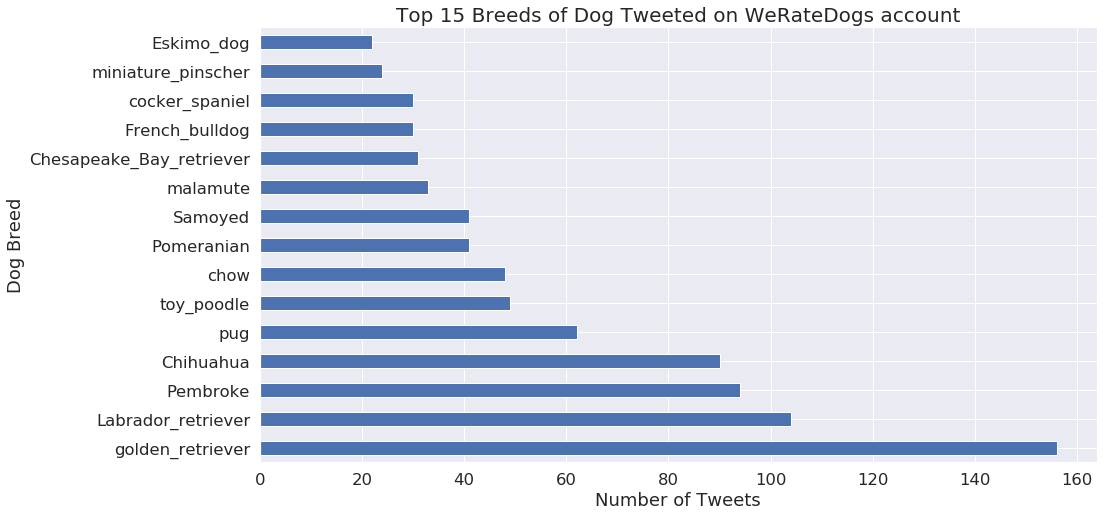

In [182]:
# Plot a horizontal bar chart to show top 15 breeds
fig = plt.figure(figsize=(15,8))
df_clean.groupby('dog_breed').count()['dog_score'].sort_values(ascending=False).nlargest(15).plot(kind='barh')
plt.title("Top 15 Breeds of Dog Tweeted on WeRateDogs account",fontsize=20)
plt.ylabel("Dog Breed")
plt.xlabel("Number of Tweets"); 

** We can see the top five tweeted dogs in order are Golden Retriever, Labrador Retriever, Pembroke Welsh Corgi, Chihuahua and Pug. **

** With the Golden Retriever receiving substantially more tweets at 156 than the other breeds. **

In [183]:
# Let's look at the ratings for each of the breeds
# Remembering to remove the 2 outliers we identified in the cleaning and the ratings for groups of dogs.
# So we take scores only from 0 to 14.
df_clean1 = df_clean[df_clean['dog_score'] <= 14] 

In [184]:
# Let's look at the statistice for all breeds removing outliers and groups.
df_clean1['dog_score'].describe()

count    1951.000000
mean       10.534085
std         2.172731
min         0.000000
25%        10.000000
50%        11.000000
75%        12.000000
max        14.000000
Name: dog_score, dtype: float64

In [185]:
# Let's group these scores by breed and have a look at some statistics.
df_clean1.groupby('dog_breed')['dog_score'].describe()

,count,mean,std,min,25%,50%,75%,max
dog_breed,,,,,,,,
Afghan_hound,3.0,9.666667,5.773503,3.0,8.00,13.0,13.00,13.0
Airedale,12.0,9.833333,2.249579,6.0,9.25,10.5,11.25,12.0
American_Staffordshire_terrier,15.0,10.133333,3.090693,0.0,10.00,11.0,11.50,13.0
Appenzeller,2.0,11.000000,2.828427,9.0,10.00,11.0,12.00,13.0
Australian_terrier,2.0,11.500000,2.121320,10.0,10.75,11.5,12.25,13.0
Bedlington_terrier,6.0,10.333333,3.141125,6.0,8.25,10.5,12.75,14.0
Bernese_mountain_dog,11.0,11.272727,1.103713,10.0,10.00,12.0,12.00,13.0
Blenheim_spaniel,10.0,11.100000,1.100505,9.0,10.25,11.5,12.00,12.0
Border_collie,12.0,10.583333,2.503028,4.0,9.75,11.5,12.00,13.0


In [186]:
# Let's look at the top scores by breed.
df_clean1.groupby('dog_breed')['dog_score'].mean().sort_values(ascending=False).nlargest(10)

dog_breed
Bouvier_des_Flandres    13.000000
Saluki                  12.500000
briard                  12.333333
Tibetan_mastiff         12.250000
Border_terrier          12.142857
standard_schnauzer      12.000000
silky_terrier           12.000000
Gordon_setter           11.750000
Irish_setter            11.750000
Samoyed                 11.731707
Name: dog_score, dtype: float64

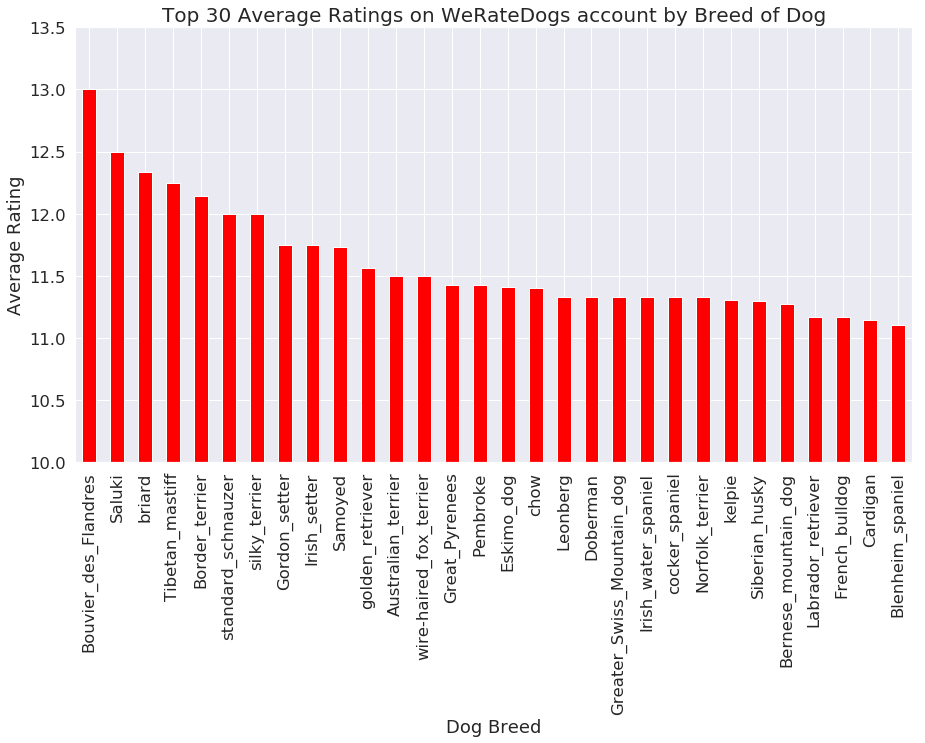

In [187]:
# Let's plot the top scores for the top 30 breeds on a standard bar chart
fig = plt.figure(figsize=(15,8))
df_clean1.groupby('dog_breed')['dog_score'].mean().sort_values(ascending=False).nlargest(30).plot(kind='bar',color='red')
plt.title("Top 30 Average Ratings on WeRateDogs account by Breed of Dog",fontsize=20)
plt.ylabel("Average Rating")
plt.xlabel("Dog Breed")
plt.ylim(10,13.5);

** So the top breeds by rating are Bouvier des Flandres, Saluki, Briard, Tibetan Mastiff and Border Terrier. These breeds are not as well-known as the breeds in our top tweeted dogs. Quickly checking I see that there is only one rating for Bouvier des Flandres. So this plot might be misleading. Let's redo the chart but include only breeds with at least 10 ratings. **  

In [189]:
# Create a variable that includes dog breeds with more than 9 counts
count = df_clean['dog_breed'].value_counts()

In [190]:
# Create a new dataframe which includes only dog breeds with at least 10 ratings
df_clean2 = df_clean[df_clean['dog_breed'].isin(count[count > 9].index)]

In [191]:
# Check the dataframe
df_clean2

,tweet_id,tweet_date,tweet_source,tweet_text,dog_name,dog_score,out_of,dog_type,dog_breed,probability_AI_calc,no_of_likes,retweet_count,tweet_url,image_link
0,667435689202614272,2015-11-19 20:14:03,Twitter for iPhone,Ermergerd 12/10 https://t.co/PQni2sjPsm,None,12,10,None,Rottweiler,1.00,303,83,https://twitter.com/dog_rates/status/667435689202614272/photo/1,https://pbs.twimg.com/media/CUM1OHCW4AEgGSi.jpg
3,667453023279554560,2015-11-19 21:22:56,Twitter Web Client,Meet Cupcake. I would do unspeakable things for Cupcake. 11/10 https://t.co/6uLCWR9Efa,Cupcake,11,10,None,Labrador_retriever,0.83,304,88,https://twitter.com/dog_rates/status/667453023279554560/photo/1,https://pbs.twimg.com/media/CUNE_OSUwAAdHhX.jpg
5,667470559035432960,2015-11-19 22:32:36,Twitter Web Client,This is a northern Wahoo named Kohl. He runs this town. Chases tumbleweeds. Draws gun wicked fast. 11/10 legendary https://t.co/J4vn2rOYFk,None,11,10,None,toy_poodle,0.30,251,96,https://twitter.com/dog_rates/status/667470559035432960/photo/1,https://pbs.twimg.com/media/CUNU78YWEAECmpB.jpg
6,667491009379606528,2015-11-19 23:53:52,Twitter Web Client,Two dogs in this one. Both are rare Jujitsu Pythagoreans. One slightly whiter than other. Long legs. 7/10 and 8/10 https://t.co/ITxxcc4v9y,None,7,10,None,borzoi,0.85,524,221,https://twitter.com/dog_rates/status/667491009379606528/photo/1,https://pbs.twimg.com/media/CUNniSlUYAEj1Jl.jpg
7,667495797102141441,2015-11-20 00:12:54,Twitter Web Client,This is Philippe from Soviet Russia. Commanding leader. Misplaced other boot. Hung flag himself. 9/10 charismatic af https://t.co/5NhPV8E45i,Philippe,9,10,None,Chihuahua,0.14,509,262,https://twitter.com/dog_rates/status/667495797102141441/photo/1,https://pbs.twimg.com/media/CUNr4-7UwAAg2lq.jpg
8,667502640335572993,2015-11-20 00:40:05,Twitter Web Client,Say hello to Hall and Oates. Oates is winking and Hall is contemplating the artistic entropy of the universe. 11/10s https://t.co/n5Wtb5Hvsl,Hall,11,10,None,Labrador_retriever,1.00,527,216,https://twitter.com/dog_rates/status/667502640335572993/photo/1,https://pbs.twimg.com/media/CUNyHTMUYAAQVch.jpg
9,667509364010450944,2015-11-20 01:06:48,Twitter Web Client,This a Norwegian Pewterschmidt named Tickles. Ears for days. 12/10 I care deeply for Tickles https://t.co/0aDF62KVP7,None,12,10,None,beagle,0.64,6686,2085,https://twitter.com/dog_rates/status/667509364010450944/photo/1,https://pbs.twimg.com/media/CUN4Or5UAAAa5K4.jpg
10,667517642048163840,2015-11-20 01:39:42,Twitter Web Client,This is Dook &amp; Milo. Dook is struggling to find who he really is and Milo is terrified of what that might be. 8/10s https://t.co/fh5KflzBR0,Dook,8,10,None,Italian_greyhound,0.13,363,188,https://twitter.com/dog_rates/status/667517642048163840/photo/1,https://pbs.twimg.com/media/CUN_wiBUkAAakT0.jpg
11,667524857454854144,2015-11-20 02:08:22,Twitter Web Client,Another topnotch dog. His name is Big Jumpy Rat. Massive ass feet. Superior tail. Jumps high af. 12/10 great pup https://t.co/seESNzgsdm,None,12,10,None,Chesapeake_Bay_retriever,0.09,1665,1088,https://twitter.com/dog_rates/status/667524857454854144/photo/1,https://pbs.twimg.com/media/CUOGUfJW4AA_eni.jpg
13,667530908589760512,2015-11-20 02:32:25,Twitter Web Client,"Meet Naphaniel. He doesn't necessarily enjoy his day job, but he's damn good at it. 10/10 https://t.co/xoRWyQTcmy",Naphaniel,10,10,None,golden_retriever,0.63,455,234,https://twitter.com/dog_rates/status/667530908589760512/photo/1,https://pbs.twimg.com/media/CUOL0uGUkAAx7yh.jpg


In [192]:
# Let's filter out the outliers and groups of dogs.
df_clean3 = df_clean2[df_clean2['dog_score'] <= 14]

In [193]:
# statistical summary for these breeds.
df_clean3.groupby('dog_breed')['dog_score'].describe()

,count,mean,std,min,25%,50%,75%,max
dog_breed,,,,,,,,
Airedale,12.0,9.833333,2.249579,6.0,9.25,10.5,11.25,12.0
American_Staffordshire_terrier,15.0,10.133333,3.090693,0.0,10.00,11.0,11.50,13.0
Bernese_mountain_dog,11.0,11.272727,1.103713,10.0,10.00,12.0,12.00,13.0
Blenheim_spaniel,10.0,11.100000,1.100505,9.0,10.25,11.5,12.00,12.0
Border_collie,12.0,10.583333,2.503028,4.0,9.75,11.5,12.00,13.0
Boston_bull,12.0,9.416667,2.108784,5.0,8.75,10.0,11.00,12.0
Cardigan,21.0,11.142857,1.590148,7.0,10.00,11.0,12.00,13.0
Chesapeake_Bay_retriever,31.0,10.838710,1.439833,8.0,10.00,10.0,12.00,13.0
Chihuahua,90.0,10.533333,2.056505,3.0,10.00,11.0,12.00,14.0


In [194]:
# Let's relook at the top scores by breed.
df_clean3.groupby('dog_breed')['dog_score'].mean().sort_values(ascending=False).nlargest(10)

dog_breed
Samoyed                 11.731707
golden_retriever        11.561290
Great_Pyrenees          11.428571
Pembroke                11.425532
Eskimo_dog              11.409091
chow                    11.404255
cocker_spaniel          11.333333
kelpie                  11.307692
Siberian_husky          11.300000
Bernese_mountain_dog    11.272727
Name: dog_score, dtype: float64

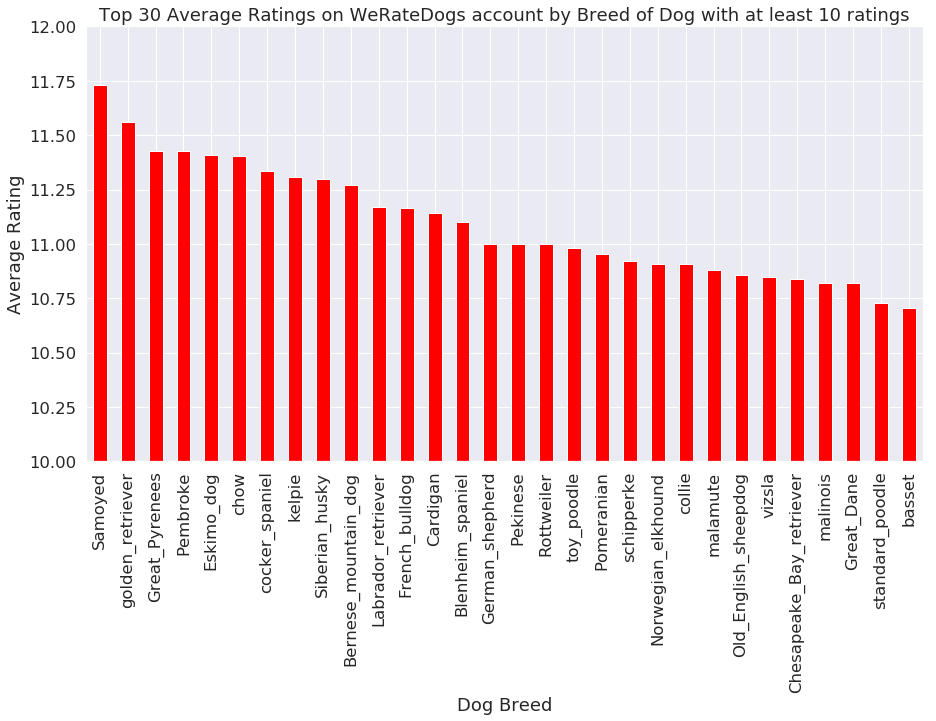

In [195]:
# Let's plot again the top scores for the top 30 breeds on a standard bar chart
fig = plt.figure(figsize=(15,8))
df_clean3.groupby('dog_breed')['dog_score'].mean().sort_values(ascending=False).nlargest(30).plot(kind='bar',color='red')
plt.title("Top 30 Average Ratings on WeRateDogs account by Breed of Dog with at least 10 ratings",fontsize=18)
plt.ylabel("Average Rating")
plt.xlabel("Dog Breed")
plt.ylim(10,12);

In [196]:
# Final analysis breeds with most average likes.
# Using the dataset filtered for breeds with more than 10 ratings, and excluding outliers and groups of dogs.
df_clean3.head()

,tweet_id,tweet_date,tweet_source,tweet_text,dog_name,dog_score,out_of,dog_type,dog_breed,probability_AI_calc,no_of_likes,retweet_count,tweet_url,image_link
0,667435689202614272,2015-11-19 20:14:03,Twitter for iPhone,Ermergerd 12/10 https://t.co/PQni2sjPsm,None,12,10,None,Rottweiler,1.00,303,83,https://twitter.com/dog_rates/status/667435689202614272/photo/1,https://pbs.twimg.com/media/CUM1OHCW4AEgGSi.jpg
3,667453023279554560,2015-11-19 21:22:56,Twitter Web Client,Meet Cupcake. I would do unspeakable things for Cupcake. 11/10 https://t.co/6uLCWR9Efa,Cupcake,11,10,None,Labrador_retriever,0.83,304,88,https://twitter.com/dog_rates/status/667453023279554560/photo/1,https://pbs.twimg.com/media/CUNE_OSUwAAdHhX.jpg
5,667470559035432960,2015-11-19 22:32:36,Twitter Web Client,This is a northern Wahoo named Kohl. He runs this town. Chases tumbleweeds. Draws gun wicked fast. 11/10 legendary https://t.co/J4vn2rOYFk,None,11,10,None,toy_poodle,0.30,251,96,https://twitter.com/dog_rates/status/667470559035432960/photo/1,https://pbs.twimg.com/media/CUNU78YWEAECmpB.jpg
6,667491009379606528,2015-11-19 23:53:52,Twitter Web Client,Two dogs in this one. Both are rare Jujitsu Pythagoreans. One slightly whiter than other. Long legs. 7/10 and 8/10 https://t.co/ITxxcc4v9y,None,7,10,None,borzoi,0.85,524,221,https://twitter.com/dog_rates/status/667491009379606528/photo/1,https://pbs.twimg.com/media/CUNniSlUYAEj1Jl.jpg
7,667495797102141441,2015-11-20 00:12:54,Twitter Web Client,This is Philippe from Soviet Russia. Commanding leader. Misplaced other boot. Hung flag himself. 9/10 charismatic af https://t.co/5NhPV8E45i,Philippe,9,10,None,Chihuahua,0.14,509,262,https://twitter.com/dog_rates/status/667495797102141441/photo/1,https://pbs.twimg.com/media/CUNr4-7UwAAg2lq.jpg


In [197]:
# Total number of likes
df_clean3['no_of_likes'].sum()

12786312

In [198]:
# Total number of likes grouped by breed
df_clean3.groupby('dog_breed')['no_of_likes'].sum() 

dog_breed
Airedale                            59392
American_Staffordshire_terrier     118987
Bernese_mountain_dog                75375
Blenheim_spaniel                    87085
Border_collie                      100900
Boston_bull                         59603
Cardigan                           252939
Chesapeake_Bay_retriever           293192
Chihuahua                          737522
English_springer                   133293
Eskimo_dog                         268611
French_bulldog                     576579
German_shepherd                    203964
Great_Dane                          65654
Great_Pyrenees                     171632
Italian_greyhound                  133384
Labrador_retriever                1140794
Lakeland_terrier                   202721
Maltese_dog                         52334
Norwegian_elkhound                 116278
Old_English_sheepdog                98585
Pekinese                            90331
Pembroke                           994521
Pomeranian              

In [199]:
# Number of tweets per dog breed
df_clean3.groupby('dog_breed')['no_of_likes'].count()

dog_breed
Airedale                           12
American_Staffordshire_terrier     15
Bernese_mountain_dog               11
Blenheim_spaniel                   10
Border_collie                      12
Boston_bull                        12
Cardigan                           21
Chesapeake_Bay_retriever           31
Chihuahua                          90
English_springer                   10
Eskimo_dog                         22
French_bulldog                     30
German_shepherd                    21
Great_Dane                         11
Great_Pyrenees                     14
Italian_greyhound                  17
Labrador_retriever                101
Lakeland_terrier                   17
Maltese_dog                        19
Norwegian_elkhound                 11
Old_English_sheepdog               14
Pekinese                           14
Pembroke                           94
Pomeranian                         41
Rottweiler                         18
Samoyed                            41
Sh

In [200]:
# Average number of likes per tweet for each dog breed
df_clean4 = round(df_clean3.groupby('dog_breed')['no_of_likes'].sum() / df_clean3.groupby('dog_breed')['no_of_likes'].count(),0)
df_clean4.sort_values(ascending=False)

dog_breed
French_bulldog                    19219.0
whippet                           13833.0
English_springer                  13329.0
standard_poodle                   13126.0
cocker_spaniel                    12982.0
Samoyed                           12939.0
Great_Pyrenees                    12259.0
Eskimo_dog                        12210.0
Cardigan                          12045.0
golden_retriever                  11931.0
Lakeland_terrier                  11925.0
Labrador_retriever                11295.0
basset                            11075.0
Pembroke                          10580.0
Norwegian_elkhound                10571.0
malamute                          10184.0
German_shepherd                    9713.0
kelpie                             9625.0
Chesapeake_Bay_retriever           9458.0
chow                               9077.0
Blenheim_spaniel                   8708.0
Border_collie                      8408.0
Chihuahua                          8195.0
boxer                   

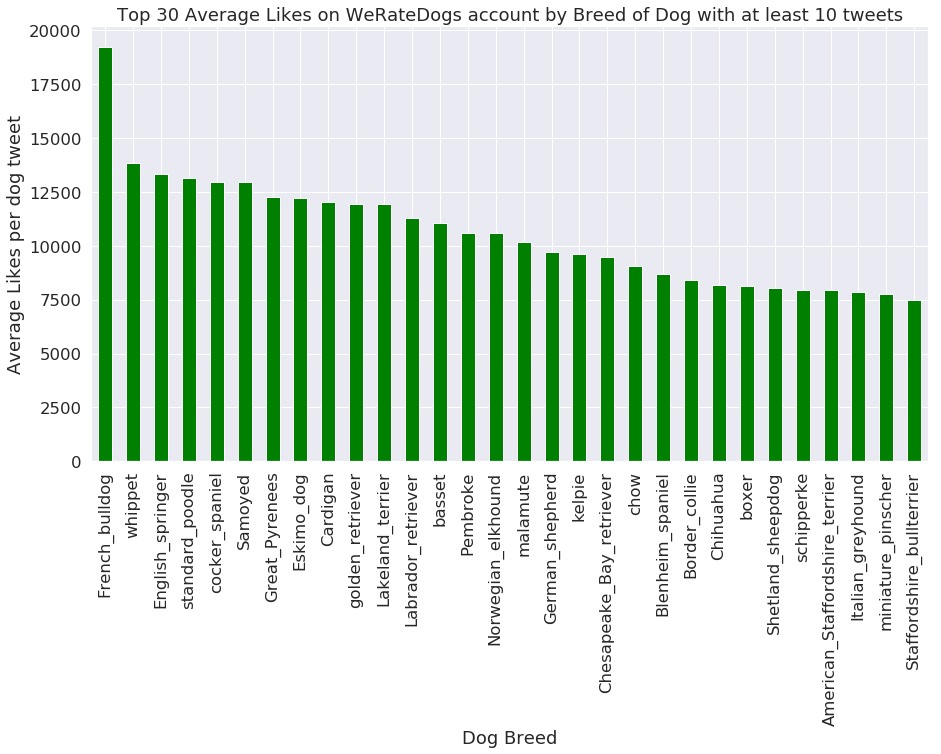

In [201]:
# Let's plot again the average most likes for the top 30 breeds on another bar chart
fig = plt.figure(figsize=(15,8))
df_clean4.sort_values(ascending=False).nlargest(30).plot(kind='bar',color='green')
plt.title("Top 30 Average Likes on WeRateDogs account by Breed of Dog with at least 10 tweets",fontsize=18)
plt.ylabel("Average Likes per dog tweet")
plt.xlabel("Dog Breed");

** So the French bulldog is clearly the dog most liked on likes/tweet. Obviously very cute to get so many likes! **   

** Also in the top 10 are Samoyed, Great Pyrenees and Golden Retriever, and at number 11 is the Labrador Retriever and number 14 the Pembroke Welsh Corgi from our other visualizations. **   

** Conclusion: The following breeds of dog seem a good place to start for further investigation into practical aspects costs, pedigree, availability, caring needs and whether my family has empathy for the breed and animal in particular. ** 

** Golden Retriever, French Bulldog, Pembroke Welsh Corgi, Samoyed, and Great Pyrenees. ** 